## `C`hain-`o`f-`V`isual-`R`esiduals: Polygon Scenario 
### - Semantic Preferences are considered

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mujoco_viewer
import openai
import cv2,os
import sys
import argparse
sys.path.append('../../')
from models.utils.util import  *
from models.env.manipulator_agent import ManipulatorAgent
from models.utils.gpt_helper import (GPT4VisionClass,printmd, response_to_json, parse_and_get_action,
                                     extract_arguments, match_objects, decode_image)
print ("openai version:[%s]"%(openai.__version__))

def extract_number(filename):
    # Extract the number from the filename using regular expression
    match = re.search(r'(\d+)', filename)
    return int(match.group()) if match else float('inf')


openai version:[1.3.8]


['1', '2', '3', '4', '5', '6', '7'] 7
['rgb_img_0.png', 'rgb_img_1.png', 'rgb_img_2.png', 'rgb_img_3.png']


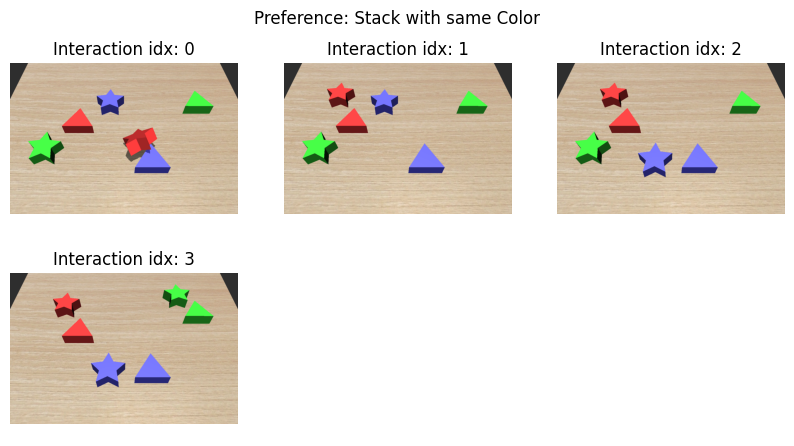

../../dataset/polygon/color/1/rgb_img_0.png
../../dataset/polygon/color/1/rgb_img_1.png
../../dataset/polygon/color/1/rgb_img_2.png
../../dataset/polygon/color/1/rgb_img_3.png
['../../dataset/polygon/color/1/rgb_img_0.png', '../../dataset/polygon/color/1/rgb_img_1.png', '../../dataset/polygon/color/1/rgb_img_2.png', '../../dataset/polygon/color/1/rgb_img_3.png']


In [3]:
interaction_accuracy_list = []
preference_list = []
token_list = []
image_token_list = []
response_error_count = 0

#%%
path = '../../dataset/polygon/color/'
# path = '../../dataset/polygon/shape/'
folders = sorted(os.listdir(path), key=lambda x: int(x.split('.')[0]))
print(folders, len(folders))

for folder_idx, folder in enumerate(folders):
    interaction_accuracy = None
    preference_accuracy = None

    images = []
    color_folder_path = os.path.join(path, folder)
    # Filter filenames that start with 'rgb_'
    rgb_filenames = [f for f in os.listdir(color_folder_path) if f.startswith('rgb_')]
    # rgb_filenames = [f for f in os.listdir(color_folder_path) if f.startswith('scene_')]
    # Sort it with ends_with number
    sorted_rgb_filenames = sorted(rgb_filenames, key=extract_number)
    print(sorted_rgb_filenames)
    plt.figure(figsize=(10, 5))
    plt.title("Preference: Stack with same Color",pad=20)
    plt.axis('off')
    for rgb_index, sotred_rgb in enumerate(sorted_rgb_filenames):
        plt.subplot(len(sorted_rgb_filenames)//2, len(sorted_rgb_filenames)//2+1, rgb_index+1)
        plt.title(f"Interaction idx: {rgb_index}")
        plt.imshow(plt.imread(os.path.join(color_folder_path, sotred_rgb)))
        plt.axis('off')
    plt.show()
    for rgb_index, sorted_rgb in enumerate(sorted_rgb_filenames):
        print(os.path.join(color_folder_path, sorted_rgb))
        path_local = os.path.join(color_folder_path, sorted_rgb)
        images.append(path_local)
    print(images)
    break

In [4]:
# 1. Start with Image description
model = GPT4VisionClass(key_path='../../key/my_key.txt', max_tokens=1024, temperature=0.9,
    gpt_model="gpt-4-vision-preview",
    role_msg="You are a helpful agent with vision capabilities; do not respond to objects not depicted in images."
    )

# 2. System prompt: functions, object_names
print("\033[94m [System prompt: infrom the format of the answer] \033[0m")


key_path:[../../key/rilab_key.txt]

Chat agent using  initialized with the follow role:[You are a helpful agent with vision capabilities; do not 
respond to objects not depicted in images.]

 [System prompt: infrom the format of the answer] 


DETAIL: high

[0/2] image_path: ../../dataset/polygon/color/1/rgb_img_0.png
[1/2] image_path: ../../dataset/polygon/color/1/rgb_img_1.png


[VISUALIZE]

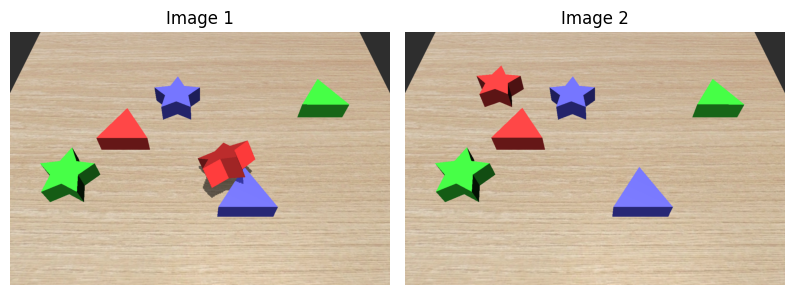

[USER_MSG]


    I will give you <img_1> and <img_2>.
    The goal is to reason about geometric and semantic properties of objects in an image sequence.
    How did the objects move between the two images? start from the <img_1> into <img_2>?
    only using the following object names: ['obj_star_green', 'obj_star_red', 'obj_star_blue', 'obj_triangle_green', 'obj_triangle_red', 'obj_triangle_blue'].
    action set: [move_object_in_front_of, move_object_to_the_left_of, move_object_to_the_right_of, move_object_behind]
    


[GPT_OUTPUT]

```json
{
  "action": "move_object_behind",
  "source_object_name": "obj_star_red",
  "source_object_color": "red",
  "source_object_shape": "star",
  "target_object_name": "obj_triangle_red",
  "target_object_color": "red",
  "target_object_shape": "triangle",
  "spatial_relation": "behind",
  "description": "obj_star_red is moved behind obj_triangle_red"
}
```
Response success!


DETAIL: high

[0/2] image_path: ../../dataset/polygon/color/1/rgb_img_1.png
[1/2] image_path: ../../dataset/polygon/color/1/rgb_img_2.png


[VISUALIZE]

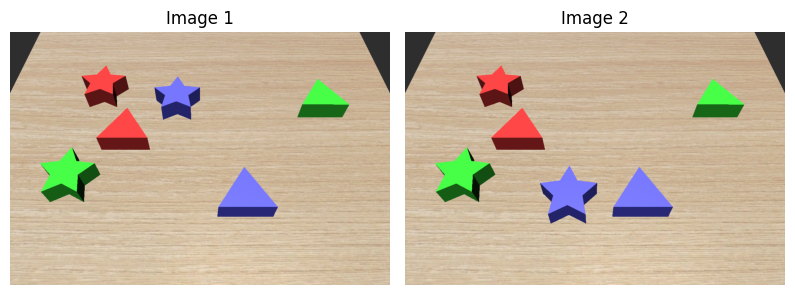

In [5]:
# I will give you the scene graph for this image that you generated in the previous step.
system_prompt = """
You will be given a set of images.
From those, your goal is to reason about the underlying preferences behind the user actions.
You ONLY Respond in JSON format. Do not include any other text in your response.
Format:
{
    "action": <action>,
    "source_object_name": <object_name>,
    "source_object_color": <object_color>,
    "source_object_shape": <object_shape>,
    "target_object_name": <object_name>,
    "target_object_color": <object_color>,
    "target_object_shape": <object_shape>,
    "spatial_relation": <spatial_relation>,
    "description": "<source_object_name> is moved <spatial_relation> <target_object_name>"
}

# source_object: the object that has moved in between these image pairs
# target_object: the object that has been involved in this movement
# spatial_relation: its resulting relationship refers to the spatial arrangement between source_object and target_object, respectively.
# REMENBER: Only one action is performed in the image sequence and the source object and the target object could be different.
"""
model.messages = model.init_messages
model.set_common_prompt(system_prompt)
model._backup_chat()

response_interaction_list = []
object_names = ["obj_star_green", "obj_star_red", "obj_star_blue", 
                "obj_triangle_green", "obj_triangle_red", "obj_triangle_blue"]
visual_residuals = []
for i in range(0, len(images)-1):
    query_text = f"""
    I will give you <img_{i+1}> and <img_{i+2}>.
    The goal is to reason about geometric and semantic properties of objects in an image sequence.
    How did the objects move between the two images? start from the <img_{i+1}> into <img_{i+2}>?
    only using the following object names: {object_names}.
    action set: [move_object_in_front_of, move_object_to_the_left_of, move_object_to_the_right_of, move_object_behind]
    """

    response_interaction = model.chat(query_text=query_text, image_paths=images[i:i+2], images=None,
                                PRINT_USER_MSG=True,
                                PRINT_GPT_OUTPUT=True,
                                RESET_CHAT=False,
                                RETURN_RESPONSE=True,
                                VISUALIZE=True,
                                DETAIL='high')
    visual_residual, error_message = response_to_json(response_interaction)
    visual_residuals.append(visual_residual)
    if len(error_message) != 0:
        response_error_count += 1
        print(len(error_message))
        print(f"Error: {error_message}")
        continue
    print("Response success!")

######## Preference Reasoning ########
preference_system_text = f"""
Let's try to analyze the images and infer the user's preference.
Under the assumption that human preferences are consistent over time and that each preference is captured through before and after interaction images.
And then user’s true preference is represented based on object's attribute (property) or spatial relationships.

We are assuming that the user's preference is defined as the following, select one of the options in number.
- Preference: ["Rearrange objects with the same color.", "Group objects by the same shape.", "Make objects into a horizontal line.", "Sort objects vertically.", "Make objects into a {{quadrants}}-side."]
The objects would be grouped into two or three categories: 
Answer Format:
- Preference: <preference>

Example:
1. grouped by colors
# If you group the objects by colors, the objects would be grouped into three categories: red, green, and blue.
- semantic-preference: same colors
- spatial-preference: None
- description: Rearrange objects with the same color.
2. grouped by shapes
# If you group the objects by shapes, the objects would be grouped into three categories: traiangle shape, and star shape.
- semantic-preference: same shapes
- spatial-preference: None
- description: Group objects by the same shape.
3. grouped by spatial relationship
# If you group the objects by spatial relationship, the objects would be grouped into patterns: horizontal line, vertical line, or quadrants: top-side, bottom-side, left-side, right-side, center.
- semantic-preference: None
- spatial-preference: horizontal line
- description: Make objects into a horizontal line.

# Only answer in each preference set.
# Answer would be one of the above examples.
"""
model.set_common_prompt(preference_system_text)
    # "spatial_preference": "<Identified spatial preference based on analysis>",

query_text = f"""
Based on previous responses, what is the user's preference?
previouse responses in sequence: {visual_residuals}

REMEMBER: Please remeber that the preference more related to the semantic meaning, not the exact precision of placing.
Answer preferences as possible as you can specify the spatial relationship between objects.
Please summarize your answer in less than three sentences based on the images and history interactions.

Format:
{{
    "preference": "<Identified preference based on visual analysis>",
    "description": "<description_about_preference>"
}}
"""
response_preference = model.chat(query_text=query_text, image_paths=images, images=None,
                            PRINT_USER_MSG=True,
                            PRINT_GPT_OUTPUT=True,
                            RESET_CHAT=False,
                            RETURN_RESPONSE=True,
                            VISUALIZE=True,
                            DETAIL='high')
preference_json, error_message = response_to_json(response_preference)
preference_list.append(response_preference)

print(model.get_total_token())